This notebook is used to 

# Libraries and Paths

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
from pytz import timezone
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Adjust your own path

In [2]:
import os

path = "/home/pw/Projects/mfstocks/code_and_data/prep_and_cleaning"

if os.getcwd() == path:
    print('Already in the correct directory!')
else:
    print('Currently in: %s' %os.getcwd())
    os.chdir(path)
    print("Changed to: %s" %os.getcwd())

Already in the correct directory!


# Time Variables

We use the raw stocks data to create time variables. Data is purchased from https://firstratedata.com/i/index/SPX, and is in US Eastern Time. 

## Reading Data
Read in the datasets for the 2019 and 2020 stocks data. Set the index of the data to the datetime index. 

In [3]:
# Read in raw data
spx = pd.read_csv(path + "/spx/SPX_2010_2020.csv",index_col='dt',parse_dates=True).sort_index()

In [4]:
spx

,high,open,low,close
dt,,,,
2019-11-01 09:30:00-04:00,3050.72,3054.69,3050.72,3054.14
2019-11-01 09:31:00-04:00,3054.28,3054.60,3053.58,3054.59
2019-11-01 09:32:00-04:00,3054.95,3054.98,3053.92,3054.02
2019-11-01 09:33:00-04:00,3053.92,3053.92,3052.77,3052.98
2019-11-01 09:34:00-04:00,3052.87,3053.48,3052.59,3053.08
...,...,...,...,...
2020-06-30 16:02:00-04:00,3100.06,3100.13,3100.06,3100.13
2020-06-30 16:03:00-04:00,3100.13,3100.23,3100.13,3100.23
2020-06-30 16:04:00-04:00,3100.23,3100.28,3100.22,3100.28


We can tell that the timezone has been added given that the datetime index now has "-04:00" or "-05:00" appended to it. 

## Adjusting date and time for data

Next, we will need to create a date range for the range we want for the analysis, then adjust our data based on this range. 

First, we create new date range for all business days (Mon-Fri), between the time of 9:30 - 16:00, from the date of 10/31/19 - 06/30/20

In [5]:
def CreateDateRange(start, end):
    rng = pd.bdate_range(start, end, freq='T', tz='US/Eastern') # creates a date range for the period for every minute
    dt = pd.DataFrame(range(len(rng)), index=rng).between_time('9:30','16:00') # limit the range to between the time of 9:30-16:00
    dt = dt.shift(freq=pd.offsets.BDay()) # limits the range to business days
    return dt

rng = CreateDateRange('2019-10-31', '2020-06-30')

Next, we reindex the new date range index onto stock data, using 'pad' to fill in the empty rows with the previous value. Reset index to datetime.

In [6]:
def AppendDateRange(daterange, data):
    newdata = data.reindex(daterange.index, method='pad') #reindex to new date range, using 'pad' to fill previous values
    newdata.index = pd.to_datetime(newdata.index) #reset to datetime
    newdata = newdata.sort_index() #sort
    return newdata

spx_adj = AppendDateRange(rng, spx)

In [7]:
spx_adj

,high,open,low,close
2019-11-01 09:30:00-04:00,3050.72,3054.69,3050.72,3054.14
2019-11-01 09:31:00-04:00,3054.28,3054.60,3053.58,3054.59
2019-11-01 09:32:00-04:00,3054.95,3054.98,3053.92,3054.02
2019-11-01 09:33:00-04:00,3053.92,3053.92,3052.77,3052.98
2019-11-01 09:34:00-04:00,3052.87,3053.48,3052.59,3053.08
...,...,...,...,...
2020-06-30 15:56:00-04:00,3105.99,3106.25,3103.48,3103.92
2020-06-30 15:57:00-04:00,3103.91,3103.91,3100.45,3101.24
2020-06-30 15:58:00-04:00,3101.45,3102.56,3100.02,3100.03
2020-06-30 15:59:00-04:00,3100.08,3105.63,3098.92,3100.17


## Save data as time variables

Now, we just need to save the new adjusted stocks data in various time periods as separate variables.

Read the datetime index into separate variables (we will use these variables to set the datetime indexes for stocks and morality variables).
1. Resample the data into various temporal resolutions
2. Set label to 'right'
3. Take the last observed data point within this time period
4. The only remaining NaN values should be the weekend values, so we can drop these.
5. Save the index of the dataframe to the variable

In [8]:
dt_15 = spx_adj.between_time('9:30','15:45').resample('15T', label='right').last().dropna().index.rename('dt_15')
dt_60 = spx_adj.between_time('9:30','14:30').resample('H', label='right', origin='start').last().dropna().index.rename('dt_60')

In [9]:
dt_60

DatetimeIndex(['2019-11-01 10:30:00-04:00', '2019-11-01 11:30:00-04:00',
               '2019-11-01 12:30:00-04:00', '2019-11-01 13:30:00-04:00',
               '2019-11-01 14:30:00-04:00', '2019-11-01 15:30:00-04:00',
               '2019-11-04 10:30:00-05:00', '2019-11-04 11:30:00-05:00',
               '2019-11-04 12:30:00-05:00', '2019-11-04 13:30:00-05:00',
               ...
               '2020-06-29 12:30:00-04:00', '2020-06-29 13:30:00-04:00',
               '2020-06-29 14:30:00-04:00', '2020-06-29 15:30:00-04:00',
               '2020-06-30 10:30:00-04:00', '2020-06-30 11:30:00-04:00',
               '2020-06-30 12:30:00-04:00', '2020-06-30 13:30:00-04:00',
               '2020-06-30 14:30:00-04:00', '2020-06-30 15:30:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='dt_60', length=1038, freq=None)

# Stocks Variables (DV)

Load the closing prices from the stocks data we read earlier. Fit the data at 2 separate time intervals (15 and 60min).

For each time interval, I took the last observed value over various periods.

In [10]:
stocks_15 = spx_adj.between_time('9:30','15:45').resample('15T', label='right').mean().dropna().close.rename('stocks_15')                     
stocks_60 = spx_adj.between_time('9:30','14:30').resample('H', label='right', origin='start').mean().dropna().close.rename('stocks_60')

In [11]:
print(stocks_15.shape)
stocks_15.head(5)

(4498,)


2019-11-01 09:45:00-04:00    3054.301333
2019-11-01 10:00:00-04:00    3056.562000
2019-11-01 10:15:00-04:00    3062.272000
2019-11-01 10:30:00-04:00    3061.774000
2019-11-01 10:45:00-04:00    3061.015333
Name: stocks_15, dtype: float64

In [12]:
print(stocks_60.shape)
stocks_60.head(9)

(1038,)


2019-11-01 10:30:00-04:00    3058.727333
2019-11-01 11:30:00-04:00    3060.903000
2019-11-01 12:30:00-04:00    3059.294667
2019-11-01 13:30:00-04:00    3059.974333
2019-11-01 14:30:00-04:00    3063.159000
2019-11-01 15:30:00-04:00    3062.830000
2019-11-04 10:30:00-05:00    3081.633500
2019-11-04 11:30:00-05:00    3081.527833
2019-11-04 12:30:00-05:00    3079.730167
Name: stocks_60, dtype: float64

# Seasonal Variables

In [13]:
# 15
intraday = list(range(1,27))
workday = list(range(1,6))

season_intraday_15 = pd.Series(intraday*173).rename('season_intraday_15')
season_workday_15 = pd.Series(26*['5'] + 34*sorted(26*workday) + 26*['1'] + 26*['2']).rename('season_workday_15')
season_month_15 = pd.Series(['11']*26*21 + ['12']*26*22 + ['1']*26*23 + ['2']*26*20 + ['3']*26*22 + ['4']*26*22 + ['5']*26*21 + ['6']*26*22).rename('season_month_15')

In [14]:
# 60
intraday = list(range(1,7))

season_intraday_60 = pd.Series(intraday*173).rename('season_intraday_60')
season_workday_60 = pd.Series(6*['5'] + 34*sorted(6*workday) + 6*['1'] + 6*['2']).rename('season_workday_60')
season_month_60 = pd.Series(['11']*6*21 + ['12']*6*22 + ['12']*6*23 + ['2-12']*6*20 + ['3-12']*6*22 + ['4-12']*6*22 + ['5-12']*6*21 + ['6-12']*6*22).rename('season_month_60')

In [15]:
season_intraday_60

0       1
1       2
2       3
3       4
4       5
       ..
1033    2
1034    3
1035    4
1036    5
1037    6
Name: season_intraday_60, Length: 1038, dtype: int64

# Morality Variables (IV)

## Reading data

Read in the merged title and emfd datasets. `emfdscore1` refers to the data collected between Nov1 - June16; `emfdscore2` refers to the data collected between June17 - June30. Data is collected in UTC time. 

In [16]:
cols1 = ['url', 'source_x', 'title_x','date','total_words', 
         'care_p', 'fairness_p', 'loyalty_p', 'authority_p','sanctity_p','care_sent', 'fairness_sent', 'loyalty_sent','authority_sent','sanctity_sent']
cols2 = ['url', 'source_x', 'title','date','total_words', 
         'care_p', 'fairness_p', 'loyalty_p', 'authority_p','sanctity_p','care_sent', 'fairness_sent', 'loyalty_sent','authority_sent','sanctity_sent']

emfdscore1 = (
    pd
    .read_csv(path + '/emfdscore/emfdscore1.csv', usecols=cols1)
    .rename(columns = {'title_x':'title'})
    .drop_duplicates(subset=['url'])
    .dropna()
)

emfdscore2 = (
    pd
    .read_csv(path + '/emfdscore/emfdscore2.csv', usecols=cols2)
    .drop_duplicates(subset=['url'])
    .dropna()
)

## Processing data

To process the data, we need to:
- Convert the date column into a datetime format
- Convert the timezone from UTC to Us Eastern
- Join the two datasets together

In [17]:
def ProcessEMFD(input1, input2):

    input1 = input1.set_index(pd.to_datetime(emfdscore1['date'], format='%Y%m%d%H%M%S')) # Set datetime index
    input2 = input2.set_index(pd.to_datetime(emfdscore2['date'], format='%Y%m%d%H%M%S'))
    
    input1.index = input1.index.tz_localize('UTC').tz_convert('US/Eastern') # Localize to UTC then convert to US Eastern Time
    input2.index = input2.index.tz_localize('UTC').tz_convert('US/Eastern') 
    
    output = pd.concat([input1[:'2020-06-15'],input2['2020-06-16':]]) #concat dataframes while removing the duplicate June16 rows
    output = output.rename(columns={'date':'datetime1'})
    output['datetime2'] = output['datetime1']
    
    return output

In [18]:
emfdscore = ProcessEMFD(emfdscore1, emfdscore2)

In [19]:
print(emfdscore.shape)
emfdscore.head(5)

(1339668, 16)


,url,source_x,title,datetime1,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2
date,,,,,,,,,,,,,,,,
2019-10-31 20:00:00-04:00,https://www.chron.com/news/crime/article/2-cau...,chron.com,2 caught with nearly 22 pounds of meth in Wyom...,2.019110e+13,0.123194,0.103551,0.072225,0.083356,0.084313,-0.231107,-0.165544,-0.134263,-0.194818,-0.278623,121.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.sfgate.com/news/us/article/The-Lat...,sfgate.com,The Latest: Census test shows citizenship has ...,2.019110e+13,0.082455,0.098696,0.078724,0.097901,0.070481,-0.113964,-0.057232,-0.002358,-0.026646,-0.030989,270.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.chron.com/news/us/article/Nevada-s...,chron.com,Nevada suit seeks to protect rare wildflower f...,2.019110e+13,0.106490,0.105956,0.083817,0.096501,0.075101,-0.107937,-0.060164,-0.029716,-0.022449,-0.083343,616.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.sfgate.com/news/us/article/Officia...,sfgate.com,Officials: Hunter did not die solely from deer...,2.019110e+13,0.158656,0.096483,0.087306,0.080506,0.082829,-0.301522,-0.265108,-0.213443,-0.292344,-0.259835,129.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.usatoday.com/story/sports/nfl/reds...,usatoday.com,"Trent Williams, Redskins OT, says he had cance...",2.019110e+13,0.092115,0.096291,0.088154,0.084048,0.078255,-0.059813,-0.022455,0.030788,-0.015616,-0.014395,665.0,2.019110e+13


## Clean problematic data


In [20]:
def RemoveSources1(data, listofsources):
    dfs = []
    for source in listofsources:
        unwanted = data[data.source_x == source]
        dfs.append(unwanted)
    final_df = pd.concat(dfs)
    
    newdata = (pd
               .merge(data, final_df, how='outer', indicator=True)
               .query('_merge == "left_only"')
               .drop(columns=['_merge'], axis=1)
               .set_index('datetime1')
              )

    newdata.index = pd.to_datetime(newdata.index, format='%Y%m%d%H%M%S')
    newdata.index = newdata.index.tz_localize('UTC').tz_convert('US/Eastern')

    return newdata

def RemoveSources2(data):
    data.index.name = None # remove index
    mw_pr = data[(data['source_x'] == 'marketwatch.com') & (data['url'].str.find('press-release') == 28)] # marketwatch_pressrelease
    data = pd.merge(data, mw_pr, how='outer',indicator=True).query('_merge == "left_only"').drop(['_merge'], axis=1)
    
    data.index = pd.to_datetime(data['datetime2'], format='%Y%m%d%H%M%S')
    data.index = data.index.tz_localize('UTC').tz_convert('US/Eastern')
    
    return data

def RemoveAll(data, listofsources):
    newdata = RemoveSources1(data, listofsources)
    newdata = RemoveSources2(newdata)
    
    return newdata

In [21]:
ls = ["forbes.com","chron.com","sfgate.com","nytimes.com","reuters.com","zerohedge.com","nbcnews.com","foxbusiness.com","fastcompany.com","chicagotribune.com",
      "businessinsider.com","breitbart.com","foxnews.com","adweek.com","cnn.com","investors.com","nbcnews.com"]
emfd = RemoveAll(emfdscore, ls)

In [22]:
print('Before removal: %d' %len(emfdscore))
print('After removal: %d' %len(emfd))

removed = len(emfdscore) - len(emfd)
print('Removed: %d rows' %removed)

Before removal: 1339668
After removal: 424668
Removed: 915000 rows


In [23]:
print(emfd.shape)
emfd.head(5)

(424668, 15)


,url,source_x,title,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2
datetime2,,,,,,,,,,,,,,,
2019-10-31 20:00:00-04:00,https://www.usatoday.com/story/sports/nfl/reds...,usatoday.com,"Trent Williams, Redskins OT, says he had cance...",0.092115,0.096291,0.088154,0.084048,0.078255,-0.059813,-0.022455,0.030788,-0.015616,-0.014395,665.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.barrons.com/articles/pinterest-sto...,barrons.com,Pinterest Stock Plunges on Sales Miss,0.096523,0.094697,0.075863,0.067788,0.081898,-0.120117,-0.006263,0.044797,0.022756,-0.061635,229.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.washingtonpost.com/opinions/global...,washingtonpost.com,Baghdadi's death could mean more American with...,0.104214,0.093182,0.094231,0.093101,0.079947,-0.109761,-0.050938,-0.028389,-0.053689,-0.046702,730.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.usatoday.com/story/news/education/...,usatoday.com,UCSC frat death: Student died after Theta Chi ...,0.110261,0.103880,0.091756,0.096471,0.080885,-0.162551,-0.117195,-0.092765,-0.097527,-0.121426,1069.0,2.019110e+13
2019-10-31 20:00:00-04:00,https://www.barrons.com/real-estate/new-develo...,barrons.com,200 Amsterdam Avenue | New Developments,0.073316,0.059442,0.074659,0.071840,0.072037,-0.001937,0.104803,0.025910,0.116755,0.069960,101.0,2.019110e+13


## Shift time

Shift time prior to GDELT reported time (as informed by RAs)

In [24]:
def ShiftTime60(data):
    data = data.shift(freq='-60T')
    return data

In [25]:
emfd60 = ShiftTime60(emfd)
print(emfd60.shape)
emfd60.head(5)

(424668, 15)


,url,source_x,title,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2
datetime2,,,,,,,,,,,,,,,
2019-10-31 19:00:00-04:00,https://www.usatoday.com/story/sports/nfl/reds...,usatoday.com,"Trent Williams, Redskins OT, says he had cance...",0.092115,0.096291,0.088154,0.084048,0.078255,-0.059813,-0.022455,0.030788,-0.015616,-0.014395,665.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.barrons.com/articles/pinterest-sto...,barrons.com,Pinterest Stock Plunges on Sales Miss,0.096523,0.094697,0.075863,0.067788,0.081898,-0.120117,-0.006263,0.044797,0.022756,-0.061635,229.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.washingtonpost.com/opinions/global...,washingtonpost.com,Baghdadi's death could mean more American with...,0.104214,0.093182,0.094231,0.093101,0.079947,-0.109761,-0.050938,-0.028389,-0.053689,-0.046702,730.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.usatoday.com/story/news/education/...,usatoday.com,UCSC frat death: Student died after Theta Chi ...,0.110261,0.103880,0.091756,0.096471,0.080885,-0.162551,-0.117195,-0.092765,-0.097527,-0.121426,1069.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.barrons.com/real-estate/new-develo...,barrons.com,200 Amsterdam Avenue | New Developments,0.073316,0.059442,0.074659,0.071840,0.072037,-0.001937,0.104803,0.025910,0.116755,0.069960,101.0,2.019110e+13


# Subset by total words

Subset data to be within the 90th percentile (0-1065 word count), to remove problematic data at the extremes. 

<AxesSubplot:xlabel='total_words', ylabel='Count'>

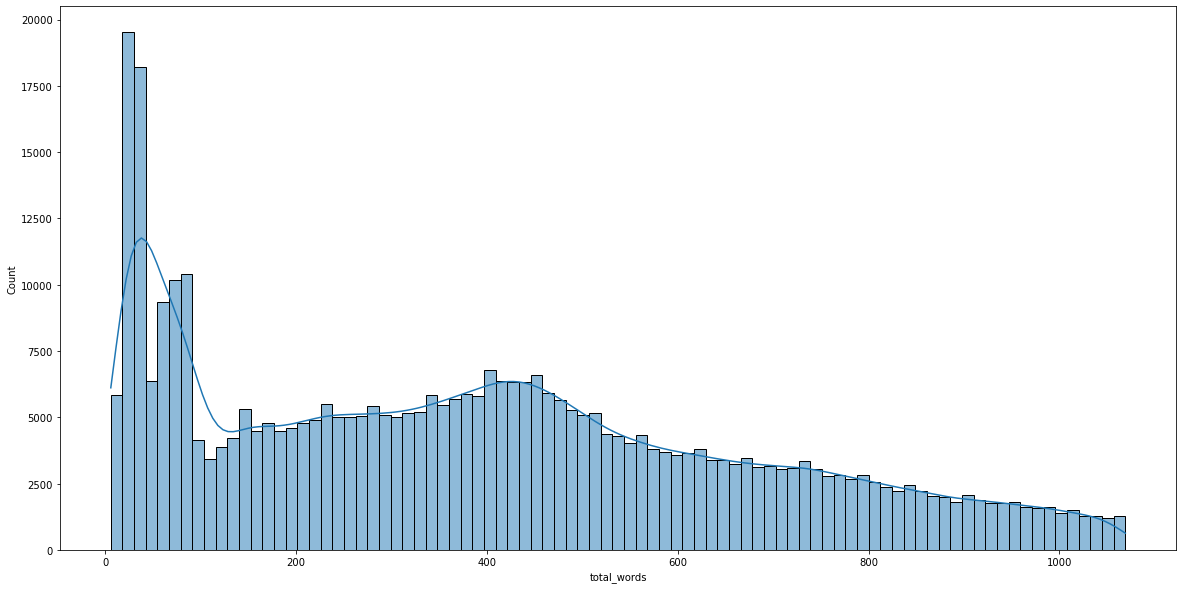

In [26]:
# final dataset, 20th - 90th percentile (169-1065 word count)

ax, fig = plt.subplots(figsize=(20,10))

upper = np.percentile(emfd['total_words'], 90)
lower = np.percentile(emfd['total_words'], 0)

data = emfd[(emfd['total_words']< upper) & (emfd['total_words']> lower)]['total_words']

sns.histplot(data=data, stat='count', kde=True)

In [27]:
def SubsetByPercentile(data):
    upper = np.percentile(data['total_words'], 90)
    lower = np.percentile(data['total_words'], 0)
    data = data[(data['total_words']< upper) & (data['total_words']> lower)]
    return data

In [28]:
emfd60subset = SubsetByPercentile(emfd60)

removed = len(emfd60) - len(emfd60subset)
print('Removed: %d rows' %removed)
print(emfd60subset.shape)
emfd60subset.head(5)

Removed: 42483 rows
(382185, 15)


,url,source_x,title,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,total_words,datetime2
datetime2,,,,,,,,,,,,,,,
2019-10-31 19:00:00-04:00,https://www.usatoday.com/story/sports/nfl/reds...,usatoday.com,"Trent Williams, Redskins OT, says he had cance...",0.092115,0.096291,0.088154,0.084048,0.078255,-0.059813,-0.022455,0.030788,-0.015616,-0.014395,665.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.barrons.com/articles/pinterest-sto...,barrons.com,Pinterest Stock Plunges on Sales Miss,0.096523,0.094697,0.075863,0.067788,0.081898,-0.120117,-0.006263,0.044797,0.022756,-0.061635,229.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.washingtonpost.com/opinions/global...,washingtonpost.com,Baghdadi's death could mean more American with...,0.104214,0.093182,0.094231,0.093101,0.079947,-0.109761,-0.050938,-0.028389,-0.053689,-0.046702,730.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.usatoday.com/story/news/education/...,usatoday.com,UCSC frat death: Student died after Theta Chi ...,0.110261,0.103880,0.091756,0.096471,0.080885,-0.162551,-0.117195,-0.092765,-0.097527,-0.121426,1069.0,2.019110e+13
2019-10-31 19:00:00-04:00,https://www.barrons.com/real-estate/new-develo...,barrons.com,200 Amsterdam Avenue | New Developments,0.073316,0.059442,0.074659,0.071840,0.072037,-0.001937,0.104803,0.025910,0.116755,0.069960,101.0,2.019110e+13


In [29]:
emfd60subset.to_csv(path + "/processed_data/emfd_processed.csv")

## Save final data as variables

Save GDELT raw data (probability and sentiments scores). Aggregated to various temporal resolutions.

First create the functions that reindex the morality data to the dt variables we setup at the beginning.

In [30]:
def moral15(data, foundation_p_sent, rename):
    foundation = data[foundation_p_sent].between_time('9:30','15:45')
    foundation = foundation.resample('15T', label='right').mean().ffill()
    foundation = foundation.rename(rename).reindex(dt_15, method=None)
    return foundation

def moral60(data, foundation_p_sent, rename):
    foundation = data[foundation_p_sent].between_time('9:30','14:30')
    foundation = foundation.resample('H', label='right', origin='start').mean()
    foundation = foundation.rename(rename).reindex(dt_60, method=None) 
    return foundation

Then create a dataframe to append all the foundation variables onto. 

In [31]:
def CreateDataframes(data, listoffoundations):
    
    data15 = pd.DataFrame()
    for f in listoffoundations:
        data15[f + '_p_15'] = moral15(data, f+'_p',f+'_p_15')
        data15[f + '_sent_15'] = moral15(data, f+'_sent',f+'_sent_15')
        
    data60 = pd.DataFrame()
    for f in listoffoundations:
        data60[f + '_p_60'] = moral60(data, f+'_p',f+'_p_60')
        data60[f + '_sent_60'] = moral60(data, f+'_sent',f+'_sent_60')

    return data15, data60

When calling the above functions, make sure you indicate which time-shifted data you are applying the functions to (i.e., to the 30-min shifted or the 60-min shifted data).

In [32]:
foundations = ['care','fairness','loyalty','authority','sanctity']
data_15, data_60 = CreateDataframes(emfd60subset, foundations)

In [33]:
data_60

,care_p_60,care_sent_60,fairness_p_60,fairness_sent_60,loyalty_p_60,loyalty_sent_60,authority_p_60,authority_sent_60,sanctity_p_60,sanctity_sent_60
dt_60,,,,,,,,,,
2019-11-01 10:30:00-04:00,0.095046,-0.089844,0.095642,-0.033934,0.086259,-0.007367,0.088101,-0.028011,0.074502,-0.052253
2019-11-01 11:30:00-04:00,0.100567,-0.100128,0.098853,-0.047767,0.090203,-0.022696,0.094394,-0.040413,0.079248,-0.065589
2019-11-01 12:30:00-04:00,0.102597,-0.103007,0.100604,-0.045678,0.088064,-0.022815,0.091175,-0.036132,0.080103,-0.067507
2019-11-01 13:30:00-04:00,0.098490,-0.111606,0.097403,-0.047671,0.087993,-0.026548,0.091922,-0.041057,0.076308,-0.068394
2019-11-01 14:30:00-04:00,0.095245,-0.096265,0.097102,-0.040766,0.087401,-0.018263,0.090700,-0.031498,0.076829,-0.069531
...,...,...,...,...,...,...,...,...,...,...
2020-06-30 11:30:00-04:00,0.100384,-0.101625,0.099569,-0.046911,0.088816,-0.011123,0.091140,-0.030335,0.077034,-0.055450
2020-06-30 12:30:00-04:00,0.093821,-0.097313,0.094336,-0.035672,0.086258,-0.007271,0.089390,-0.022535,0.075768,-0.041312
2020-06-30 13:30:00-04:00,0.098784,-0.095413,0.097751,-0.033782,0.087541,-0.003241,0.089836,-0.021547,0.078251,-0.042488


# Transfer Function Code



tf2: Measuring mid-stockmarket crash, where pre < 2020-02-20 < mid < 2020-04-07 < post). Informed by dates for official entry into and out of 2020 market crash. 
Coded [Pre=0, Mid=1, Post=0]

In [34]:
tf2_15 = (
    pd
    .Series([0]*len(stocks_15[:'2020-02-19']) + 
            [1]*len(stocks_15['2020-02-20':'2020-04-06']) + 
            [0]*len(stocks_15['2020-04-07':]))
    .rename('tf2_15')
)

tf2_60 = (
    pd
    .Series([0]*len(stocks_60[:'2020-02-19']) + 
            [1]*len(stocks_60['2020-02-20':'2020-04-06']) + 
            [0]*len(stocks_60['2020-04-07':]))
    .rename('tf2_60')
)

# Putting the Datasets Together

In [35]:
# 15 min
ls1 = [dt_15, season_intraday_15, season_workday_15, season_month_15, stocks_15, tf2_15] 
for i in ls1:
    data_15 = pd.concat([data_15.reset_index(drop=True), pd.DataFrame(i).reset_index(drop=True)], axis=1)
    
# 60 min
ls2 = [dt_60, season_intraday_60, season_workday_60, season_month_60, stocks_60, tf2_60]
for i in ls2:
    data_60 = pd.concat([data_60.reset_index(drop=True), pd.DataFrame(i).reset_index(drop=True)], axis=1)


In [36]:
data_60

,care_p_60,care_sent_60,fairness_p_60,fairness_sent_60,loyalty_p_60,loyalty_sent_60,authority_p_60,authority_sent_60,sanctity_p_60,sanctity_sent_60,dt_60,season_intraday_60,season_workday_60,season_month_60,stocks_60,tf2_60
0,0.095046,-0.089844,0.095642,-0.033934,0.086259,-0.007367,0.088101,-0.028011,0.074502,-0.052253,2019-11-01 10:30:00-04:00,1,5,11,3058.727333,0
1,0.100567,-0.100128,0.098853,-0.047767,0.090203,-0.022696,0.094394,-0.040413,0.079248,-0.065589,2019-11-01 11:30:00-04:00,2,5,11,3060.903000,0
2,0.102597,-0.103007,0.100604,-0.045678,0.088064,-0.022815,0.091175,-0.036132,0.080103,-0.067507,2019-11-01 12:30:00-04:00,3,5,11,3059.294667,0
3,0.098490,-0.111606,0.097403,-0.047671,0.087993,-0.026548,0.091922,-0.041057,0.076308,-0.068394,2019-11-01 13:30:00-04:00,4,5,11,3059.974333,0
4,0.095245,-0.096265,0.097102,-0.040766,0.087401,-0.018263,0.090700,-0.031498,0.076829,-0.069531,2019-11-01 14:30:00-04:00,5,5,11,3063.159000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.100384,-0.101625,0.099569,-0.046911,0.088816,-0.011123,0.091140,-0.030335,0.077034,-0.055450,2020-06-30 11:30:00-04:00,2,2,6-12,3073.216167,0
1034,0.093821,-0.097313,0.094336,-0.035672,0.086258,-0.007271,0.089390,-0.022535,0.075768,-0.041312,2020-06-30 12:30:00-04:00,3,2,6-12,3078.580833,0
1035,0.098784,-0.095413,0.097751,-0.033782,0.087541,-0.003241,0.089836,-0.021547,0.078251,-0.042488,2020-06-30 13:30:00-04:00,4,2,6-12,3074.033667,0
1036,0.093039,-0.095993,0.093347,-0.032414,0.085693,-0.010536,0.088165,-0.027364,0.075355,-0.046048,2020-06-30 14:30:00-04:00,5,2,6-12,3073.353000,0


In [37]:
def OrderColumns(data1, data2):
    times = ['_15','_60']
    listofcols = []
    for t in times:
        cols = ['dt'+t, 'season_intraday'+t, 'season_workday'+t, 'season_month'+t, 'stocks'+t, 
            'care_p'+t, 'fairness_p'+t, 'loyalty_p'+t, 'authority_p'+t, 'sanctity_p'+t, 
            'care_sent'+t, 'fairness_sent'+t, 'loyalty_sent'+t, 'authority_sent'+t, 'sanctity_sent'+t, 
                'tf2'+t]
        listofcols.append(cols)
    
    data1 = data1[listofcols[0]]
    data2 = data2[listofcols[1]]
    
    return data1, data2

In [38]:
data_15, data_60 = OrderColumns(data_15, data_60)

In [39]:
data_60

,dt_60,season_intraday_60,season_workday_60,season_month_60,stocks_60,care_p_60,fairness_p_60,loyalty_p_60,authority_p_60,sanctity_p_60,care_sent_60,fairness_sent_60,loyalty_sent_60,authority_sent_60,sanctity_sent_60,tf2_60
0,2019-11-01 10:30:00-04:00,1,5,11,3058.727333,0.095046,0.095642,0.086259,0.088101,0.074502,-0.089844,-0.033934,-0.007367,-0.028011,-0.052253,0
1,2019-11-01 11:30:00-04:00,2,5,11,3060.903000,0.100567,0.098853,0.090203,0.094394,0.079248,-0.100128,-0.047767,-0.022696,-0.040413,-0.065589,0
2,2019-11-01 12:30:00-04:00,3,5,11,3059.294667,0.102597,0.100604,0.088064,0.091175,0.080103,-0.103007,-0.045678,-0.022815,-0.036132,-0.067507,0
3,2019-11-01 13:30:00-04:00,4,5,11,3059.974333,0.098490,0.097403,0.087993,0.091922,0.076308,-0.111606,-0.047671,-0.026548,-0.041057,-0.068394,0
4,2019-11-01 14:30:00-04:00,5,5,11,3063.159000,0.095245,0.097102,0.087401,0.090700,0.076829,-0.096265,-0.040766,-0.018263,-0.031498,-0.069531,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2020-06-30 11:30:00-04:00,2,2,6-12,3073.216167,0.100384,0.099569,0.088816,0.091140,0.077034,-0.101625,-0.046911,-0.011123,-0.030335,-0.055450,0
1034,2020-06-30 12:30:00-04:00,3,2,6-12,3078.580833,0.093821,0.094336,0.086258,0.089390,0.075768,-0.097313,-0.035672,-0.007271,-0.022535,-0.041312,0
1035,2020-06-30 13:30:00-04:00,4,2,6-12,3074.033667,0.098784,0.097751,0.087541,0.089836,0.078251,-0.095413,-0.033782,-0.003241,-0.021547,-0.042488,0
1036,2020-06-30 14:30:00-04:00,5,2,6-12,3073.353000,0.093039,0.093347,0.085693,0.088165,0.075355,-0.095993,-0.032414,-0.010536,-0.027364,-0.046048,0


In [40]:
# Saving the files

parent = os.path.dirname(path)

data_15.to_csv(parent + '/analysis/data_15.csv', index=None)
data_60.to_csv(parent + '/analysis/data_60.csv', index=None)

In [41]:
data_60

,dt_60,season_intraday_60,season_workday_60,season_month_60,stocks_60,care_p_60,fairness_p_60,loyalty_p_60,authority_p_60,sanctity_p_60,care_sent_60,fairness_sent_60,loyalty_sent_60,authority_sent_60,sanctity_sent_60,tf2_60
0,2019-11-01 10:30:00-04:00,1,5,11,3058.727333,0.095046,0.095642,0.086259,0.088101,0.074502,-0.089844,-0.033934,-0.007367,-0.028011,-0.052253,0
1,2019-11-01 11:30:00-04:00,2,5,11,3060.903000,0.100567,0.098853,0.090203,0.094394,0.079248,-0.100128,-0.047767,-0.022696,-0.040413,-0.065589,0
2,2019-11-01 12:30:00-04:00,3,5,11,3059.294667,0.102597,0.100604,0.088064,0.091175,0.080103,-0.103007,-0.045678,-0.022815,-0.036132,-0.067507,0
3,2019-11-01 13:30:00-04:00,4,5,11,3059.974333,0.098490,0.097403,0.087993,0.091922,0.076308,-0.111606,-0.047671,-0.026548,-0.041057,-0.068394,0
4,2019-11-01 14:30:00-04:00,5,5,11,3063.159000,0.095245,0.097102,0.087401,0.090700,0.076829,-0.096265,-0.040766,-0.018263,-0.031498,-0.069531,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2020-06-30 11:30:00-04:00,2,2,6-12,3073.216167,0.100384,0.099569,0.088816,0.091140,0.077034,-0.101625,-0.046911,-0.011123,-0.030335,-0.055450,0
1034,2020-06-30 12:30:00-04:00,3,2,6-12,3078.580833,0.093821,0.094336,0.086258,0.089390,0.075768,-0.097313,-0.035672,-0.007271,-0.022535,-0.041312,0
1035,2020-06-30 13:30:00-04:00,4,2,6-12,3074.033667,0.098784,0.097751,0.087541,0.089836,0.078251,-0.095413,-0.033782,-0.003241,-0.021547,-0.042488,0
1036,2020-06-30 14:30:00-04:00,5,2,6-12,3073.353000,0.093039,0.093347,0.085693,0.088165,0.075355,-0.095993,-0.032414,-0.010536,-0.027364,-0.046048,0
